In [76]:
import pandas as pd
import os
from dotenv import load_dotenv
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# define constants 
NTT_PATH = "./data/ntt_data"
COVID_PATH = "./data/covid_data"
WEATHER_PATH = "./data/weather"

In [78]:
# # load shinagawa station data 
# tokyo_df = pd.read_csv(f"{NTT_PATH}/shibs_sample.csv")

In [79]:
# load shibuya station data
shibuya_cov_df = pd.read_csv(f"{NTT_PATH}/shibuya_daily_pop_covid.csv")
shibuya_cov_df['date'] = pd.to_datetime(shibuya_cov_df['date'])
shibuya_cov_df.head()

,date,daily_avg_population,total_new_cases,tokyo_new_cases,total_weekly_diff,tokyo_weekly_diff,total_severe_cases,tokyo_severe_cases,total_cum_deaths,tokyo_cum_deaths,...,soe2,soe3,soe4,semi-soe1,semi-soe2,wave1,wave2,wave3,wave4,wave5
0,2020-01-16,154303.791667,1,0,1,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-17,157210.208333,0,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-18,122870.750000,0,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-19,114384.000000,0,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-20,149521.666667,0,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# xgboost on dataset 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# prepare data for XGBoost

# create day of the week dummy variables
shibuya_cov_df['weekday'] = shibuya_cov_df['date'].dt.weekday
shibuya_cov_df = pd.get_dummies(shibuya_cov_df, columns=['weekday'], prefix='weekday')

# create Japanese holiday dummy variables
from jpholiday import is_holiday
shibuya_cov_df['holiday'] = shibuya_cov_df['date'].apply(lambda x: 1 if is_holiday(x) else 0)

# set date as index
shibuya_cov_df.set_index('date', inplace=True)

# select the columns to use as features and target
features = shibuya_cov_df.drop(['daily_avg_population'], axis=1)
target = shibuya_cov_df['daily_avg_population']

# split data into training and test sets
train_size = int(len(shibuya_cov_df) * 0.7)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set XGBoost parameters
params = {'objective': 'reg:squarederror',
          'eval_metric': 'rmse',
          'seed': 0}

# train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# make predictions on test data
predictions = model.predict(dtest)

# evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')


RMSE: 10346.891501413635


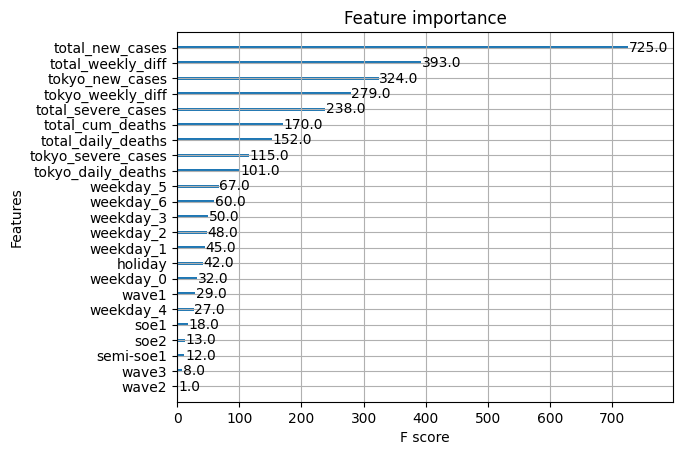

In [81]:
# plot feature importance
xgb.plot_importance(model)

# show plot
plt.show()

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# create lag variables
shibuya_cov_df['total_new_cases_lag'] = shibuya_cov_df['total_new_cases'].shift(1)
shibuya_cov_df['tokyo_new_cases_lag'] = shibuya_cov_df['tokyo_new_cases'].shift(1)
shibuya_cov_df['total_weekly_diff_lag'] = shibuya_cov_df['total_weekly_diff'].shift(1)
shibuya_cov_df['tokyo_weekly_diff_lag'] = shibuya_cov_df['tokyo_weekly_diff'].shift(1)
shibuya_cov_df['total_severe_cases_lag'] = shibuya_cov_df['total_severe_cases'].shift(1)
shibuya_cov_df['tokyo_severe_cases_lag'] = shibuya_cov_df['tokyo_severe_cases'].shift(1)
shibuya_cov_df['total_cum_deaths_lag'] = shibuya_cov_df['total_cum_deaths'].shift(1)
shibuya_cov_df['tokyo_cum_deaths_lag'] = shibuya_cov_df['tokyo_cum_deaths'].shift(1)
shibuya_cov_df['total_daily_deaths_lag'] = shibuya_cov_df['total_daily_deaths'].shift(1)
shibuya_cov_df['tokyo_daily_deaths_lag'] = shibuya_cov_df['tokyo_daily_deaths'].shift(1)

# prepare data for linear regression
reg_df = shibuya_cov_df[[
    'daily_avg_population',
    'total_new_cases_lag',
    'tokyo_new_cases_lag',
    'total_weekly_diff_lag',
    'tokyo_weekly_diff_lag',
    'soe1', 
    'soe2', 
    'soe3',
    'soe4', 
    'semi-soe1', 
    'semi-soe2', 
    'wave1', 
    'wave2', 
    'wave3', 
    'wave4',
    'wave5',
    'holiday',
    'weekday_0',    
    'weekday_1',  
    'weekday_2',    
    'weekday_3',    
    'weekday_4',    
    'weekday_5',    
    'weekday_6',   
    ]]

# REMOVED FOLLOWING DUE TO NA VALUES 
    # 'total_severe_cases_lag',
    # 'tokyo_severe_cases_lag',
    # 'total_cum_deaths_lag',
    # 'tokyo_cum_deaths_lag',
    # 'total_daily_deaths_lag', 
    # 'tokyo_daily_deaths_lag',

reg_df = reg_df.dropna(axis=0)

# select the columns to use as features and target
X = reg_df.drop(['daily_avg_population'], axis=1)
y = reg_df['daily_avg_population']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# train linear regression model
reg = LinearRegression().fit(X_train, y_train)

# make predictions on test data
y_pred = reg.predict(X_test)

# evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}, R2: {r2}')


RMSE: 10491.424991773269, R2: 0.7514952368158496


In [83]:
import statsmodels.api as sm

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     daily_avg_population   R-squared:                       0.772
Model:                              OLS   Adj. R-squared:                  0.765
Method:                   Least Squares   F-statistic:                     106.7
Date:                  Tue, 17 Jan 2023   Prob (F-statistic):          2.90e-205
Time:                          14:04:47   Log-Likelihood:                -7614.2
No. Observations:                   715   AIC:                         1.527e+04
Df Residuals:                       692   BIC:                         1.538e+04
Df Model:                            22                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [84]:
X = X.drop(['total_new_cases_lag'], axis=1)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     daily_avg_population   R-squared:                       0.772
Model:                              OLS   Adj. R-squared:                  0.765
Method:                   Least Squares   F-statistic:                     111.9
Date:                  Tue, 17 Jan 2023   Prob (F-statistic):          2.76e-206
Time:                          14:04:52   Log-Likelihood:                -7614.3
No. Observations:                   715   AIC:                         1.527e+04
Df Residuals:                       693   BIC:                         1.537e+04
Df Model:                            21                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

# Todo:   
- aggregate by time window  (work hours, day/night interactions with covid cases, media urgency)
- add log to variables
- look into DiD design for SOE 
- look into language announcing SOE  
